# Cyclostationary Analysis

***
#### Author: Fabio Casagrande Hirono 

*fchirono [at] gmail.com*

November 2022
*** 
This notebook contains my current explorations into cyclostationary signal analysis. Please note the code below is a work in progress!

I'm using as main references Dr. Chad Spooner's blog ["*Clyclostationary Signal Processing*"](https://cyclostationary.blog), and the following paper by Prof W. Gardner:

> W. A. Gardner, *EXPLOITATION OF SPECTRAL REDUNDANCY IN CYCLOSTATIONARY SIGNALS*, IEEE Signal Processing Magazine, Vol. 8, No. 2, pp. 14-36, 1991. Available [here](https://cyclostationarity.com/wp-content/uploads/2021/06/Signal-Processing.pdf)

[* Many thanks to Dr. Spooner for his help in improving this code!]

The code begins by importing some Python packages, and defining functions to estimate our cyclostationary densities and coherences. I am using the [Time-Smoothing Method (TSM)](https://cyclostationary.blog/2015/12/18/csp-estimators-the-time-smoothing-method/), and the code allows calculating either the [*non-conjugate* or the *conjugate* spectral correlation density](https://cyclostationary.blog/2016/02/29/conjugation-configurations/).

In [1]:
import numpy as np
rng = np.random.default_rng()

import scipy.signal as ss

import matplotlib.pyplot as plt
plt.close('all')


# ********************************************************************************
def calc_xspec_block(x, y, t, alpha=0):
    """
    Calculate cross-spectrum for one block of data over time samples 't',
    optionally including cyclic frequency shift 'alpha'.

    Parameters
    ----------
    x : (N,)-shaped array_like
        Numpy array containing one 'N'-samples-long block of data from signal
        'x'.

    y : (N,)-shaped array_like
        Numpy array containing one 'N'-samples-long block of data from signal
        'y'.

    t : (N,)-shaped array_like
        Numpy array containing one 'N'-samples-long block of time values, in
        seconds.

    alpha : float, optional
        Cyclic frequency 'alpha', in Hz. Default is 0.


    Returns
    -------
    Suu : (N,)-shaped array_like
        Numpy array containing 'N'-long auto-power spectrum of signal 'x',
        frequency-shifted by +'alpha'/2.

    Svv : (N,)-shaped array_like
        Numpy array containing 'N'-long auto-power spectrum of signal 'y',
        frequency-shifted by -'alpha'/2.

    Suv : (N,)-shaped array_like
        Numpy array containing 'N'-long cross-power spectrum of signal 'x'
        frequency-shifted by +'alpha'/2, and signal 'y' frequency-shifted
        by -'alpha'/2.

    """

    # applies frequency shift of +/- alpha/2
    u_block = x*np.exp(-1j*np.pi*alpha*t)
    v_block = y*np.exp(+1j*np.pi*alpha*t)

    # take FFT of data blocks
    u_f = np.fft.fft(u_block)
    v_f = np.fft.fft(v_block)

    # calculates auto- and cross-power spectra
    Suu = (u_f * u_f.conj()).real
    Svv = (v_f * v_f.conj()).real
    Suv = (u_f * v_f.conj())
    
    return Suu, Svv, Suv


def cyclic_periodogram(x, y, alpha_vec, Ndft, fs, mode='non-conj'):
    """
    Calculates cyclic spectral density and cyclic spectral coherence using
    periodogram (time-smoothing) method.

    Parameters
    ----------
    x : (Nt,)-shaped array_like
        Numpy array containing 'Nt' time-domain samples of signal 'x'.

    y : (Nt,)-shaped array_like
        Numpy array containing 'Nt' time-domain samples of signal 'y'.

    alpha_vec : (N_alpha,)-shaped array_like
        Numpy array containing 'N_alpha' values of cyclic frequency 'alpha',
        in Hz.

    Ndft : int
        Number of points used in calculating the Discrete Fourier Transform.

    fs : float
        Sampling frequency, in Hz.

    mode : {'non-conj', 'conj'}, optional
        String defining whether output is non-conjugate CSD and coherence,
        or conjugate CSD and coherence. Default is 'non-conj'.

    Returns
    -------
    Sxy_avg : (N_alpha, Ndft)-shaped array_like
        Numpy array containing the cyclic spectral density 'Sxy', evaluated at
        'Ndft' frequencies for each cyclic frequency 'alpha'.

    cohere : (N_alpha, Ndft)-shaped array_like
        Numpy array containing the cyclic coherence 'cohere', evaluated at
        'Ndft' frequencies for each cyclic frequency 'alpha'.
    """

    N_alpha = alpha_vec.shape[0]

    Nt = x.shape[0]
    N_blocks = Nt//Ndft


    df = fs/Ndft
    freq = np.linspace(0, fs-df, Ndft)-fs/2

    # Spectral Correlation Density (SCD) function
    Sxx = np.zeros((N_blocks, N_alpha, Ndft))
    Syy = np.zeros((N_blocks, N_alpha, Ndft))
    Sxy = np.zeros((N_blocks, N_alpha, Ndft), dtype='complex')

    # If calculating the *conjugate* SCF/coherence
    if mode=='conj':
        y = y.conj()

    for n in range(N_blocks):

        n_start = n*Ndft
        t_block = np.linspace(n_start/fs, (n_start+Ndft)/fs, Ndft)

        x_block = x[n_start : n_start+Ndft]
        y_block = y[n_start : n_start+Ndft]

        # calculate spectra for alpha values in 'alpha_vec'
        for a, alpha in enumerate(alpha_vec):
            Sxx[n, a, :], Syy[n, a, :], Sxy[n, a, :] = calc_xspec_block(x_block, y_block,
                                                                        t_block, alpha)

    Sxx *= 1/(Ndft*fs)
    Syy *= 1/(Ndft*fs)
    Sxy *= 1/(Ndft*fs)
            
    # apply FFT shift
    Sxx = np.fft.fftshift(Sxx, axes=(-1))
    Syy = np.fft.fftshift(Syy, axes=(-1))
    Sxy = np.fft.fftshift(Sxy, axes=(-1))

    # average over blocks
    Sxx_avg = Sxx.sum(axis=0)/N_blocks
    Syy_avg = Syy.sum(axis=0)/N_blocks
    Sxy_avg = Sxy.sum(axis=0)/N_blocks

    cohere = Sxy_avg/np.sqrt(Sxx_avg*Syy_avg)

    # replace entries outside the principal domain in freq-alpha plane by NaNs
    # (i.e. diamond shape given by |f| > (fs-|alpha|)/2 )
    for a, alpha in enumerate(alpha_vec):
        freqs_outside = (np.abs(freq) > (fs - np.abs(alpha))/2)
        Sxy_avg[a, freqs_outside] = np.nan
        cohere[a, freqs_outside] = np.nan

    return Sxy_avg, cohere



C:\Users\ses165\Miniconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


We now define some functions to generate test signals that exhibit cyclostationarity. Our test signals are a [rectangular-pulse Binary Phase-Shift Keyed (BPSK) signal](https://cyclostationary.blog/2015/09/28/creating-a-simple-cs-signal-rectangular-pulse-bpsk/), and bandlimited Gaussian noise modulating a cosine wave (as described in Gardner's paper). We also define a function to generate additive random noise at a given SNR.

In [2]:
def create_rect_bpsk(T_bits, num_bits, fc, signal_power_dB):
    """
    Generate a rectangular-pulse binary phase-shift keyed signal, as described in
    https://cyclostationary.blog/2015/09/28/creating-a-simple-cs-signal-rectangular-pulse-bpsk/

    Parameters
    ----------
    T_bits : int
        Number of samples per bit. Note that '1/T_bit' is the bit rate.

    num_bits : int
        Desired number of bits in the signal.

    fc : float
        Desired carrier frequency, in normalised units.

    signal_power_dB : float
        Desired signal power, in decibels.

    Returns
    -------
    x_t : (N_t,)-shaped array_like
        Numpy array containing the time-domain, frequency-shifted signal samples.

    """

    N_samples = num_bits*T_bits

    # Create bit sequence - 0s and 1s
    bit_seq = rng.integers(0, 2, num_bits)

    # Create symbol sequence from bit sequence (-1s and +1s)
    sym_seq = 2*bit_seq - 1

    # generate symbol sequence by intercalating each bit with (T_bits-1) zeros
    zero_mat = np.zeros((T_bits-1, num_bits))
    sym_seq = np.concatenate((sym_seq[np.newaxis, :], zero_mat), axis=0)
    sym_seq = np.reshape(sym_seq, (N_samples,), order='F')

    # Create rectangular pulse function
    p_t = np.ones((T_bits,))

    # Convolve bit sequence with pulse function to obtain rectangular-pulse
    # BPSK signal
    s_t = ss.lfilter(p_t, [1], sym_seq)

    # Apply the carrier frequency.
    e_vec = np.exp(1j*2*np.pi*fc*np.arange(N_samples))
    x_t = s_t * e_vec

    # normalise signal power to 'signal_power_dB'
    signal_power = 10**(signal_power_dB/10)
    x_t *= np.sqrt(signal_power/np.var(x_t))

    return x_t


# ********************************************************************************
def create_lowpassmod_cos(N_samples, N_filter, fc_filter, f_cos, fs,
                          signal_power_dB):
    """
    Generate bandlimited Gaussian noise, modulating a unitary-amplitude cosine
    wave at 'f_cos' Hz. The Gaussian noise is lowpassed at 'fc_filter' Hz
    using a Butterworth filter of order 'N_filter'.

    Parameters
    ----------
    N_samples : int
        Number of time-domain samples in the output signal.

    N_filter : int
        Filter order used to generate lowpassed Gaussian random samples.

    fc_filter : float
        Cutoff frequency, in Hz, used to generate lowpassed Gaussian random
        samples.

    f_cos : float
        Frequency of the cosine wave, in Hz.

    fs : float
        Sampling frequency, in Hz.

    signal_power_dB : float
        Desired output signal power, in decibels.

    Returns
    -------
    x : (N_samples,)-shaped array_like
        Numpy array containing the time-domain signal samples.

    """

    # define lowpass Butterworth filter
    butter_sos = ss.butter(N_filter, fc_filter, output='sos', fs=fs)

    # create band-limited Gaussian white noise
    xn = rng.normal(loc=0, scale=1, size=N_samples)
    x_lpn = ss.sosfilt(butter_sos, xn)

    # generate cosine wave at 'fc' Hz
    t = np.linspace(0, (N_samples-1)/fs, N_samples)
    xc = np.cos(2*np.pi*f_cos*t)

    x = x_lpn*xc

    # normalise signal power to 'signal_power_dB'
    signal_power = 10**(signal_power_dB/10)
    x *= np.sqrt(signal_power/np.var(x))

    return x


# ********************************************************************************
def create_noise(x_t, SNR_dB):
    """
    Returns a real- or complex-valued Gaussian random noise signal, which
    yields a given Signal-to-Noise Ratio (SNR) in decibels when added to the
    input signal 'x_t'.

    Noise samples follow the same data type (real or complex) as input
    signal 'x_t'.

    Parameters
    ----------
    x_t : (N_t,)-shaped array_like
        Numpy array containing the time-domain signal samples.

    SNR_dB : float
        Desired signal-to-noise ratio, in decibels.

    Returns
    -------
    noise_t : (N_t,)-shaped array_like
        Numpy array containing the time-domain noise samples.

    """

    N_t = x_t.shape[0]
    signal_power = np.var(x_t)

    # generate real-valued Gaussian random samples
    noise_t = rng.normal(0, 1, N_t)

    # if 'x' is complex, adds complex-valued Gaussian random samples to
    # 'noise_t'
    if np.iscomplexobj(x_t):
        noise_t = noise_t + 1j*rng.normal(0, 1, N_t)

    noise_power = np.var(noise_t)

    SNR_lin = 10**(SNR_dB/10)
    desired_noise_power = signal_power/SNR_lin

    # renormalise noise power to yield desired SNR
    noise_t *= np.sqrt(desired_noise_power/noise_power)

    return noise_t



Let's use the functions above to create a test signal, and add random Gaussian white noise at a desired SNR. Let's also compare the first few samples of the original versus the noisy signal.

In the cell below, comment/uncomment the desired option at the top to choose a signal, and feel free to change the signal parameters.

Desired SNR = 10.0 dB
Resulting SNR = 10.0 dB


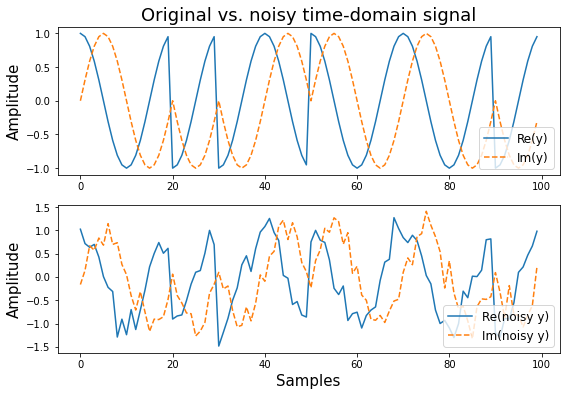

In [3]:
# ********************************************************************************
# comment/uncomment desired option

signal = 'bpsk'
# signal = 'lowpassmod_cos'

# ********************************************************************************

# sampling frequency
fs = 1

if signal == 'bpsk':
    # -----------------------------------------------------------------------------
    # rect BPSK signal

    T_bits = 10                 # Number of samples per bit (1/T_bit is the bit rate)
    num_bits = 32768            # Desired number of bits in generated signal
    fc = 0.05                   # Desired carrier frequency (normalized units)

    signal_power_dB = 0.0       # Signal power in decibels
    noise_power_dB = -10.0      # Noise spectral density (average noise power)

    T = (num_bits*T_bits)/fs
    y = create_rect_bpsk(T_bits, num_bits, fc, signal_power_dB)
    # -----------------------------------------------------------------------------

elif signal == 'lowpassmod_cos':
    # -----------------------------------------------------------------------------
    # bandlimited Gaussian white noise modulating a cosine wave
    N_samples = 327680

    # lowpassed white noise parameters
    N_filter = 6                # lowpass filter order (Butterworth)
    fc_filter = 0.05*fs         # lowpass filter cutoff freq
    f_cos = 0.15*fs             # cosine wave frequency

    signal_power_dB = 0.0       # Signal power in decibels
    noise_power_dB = -10.0      # Noise spectral density (average noise power)

    T = N_samples/fs
    y = create_lowpassmod_cos(N_samples, N_filter, fc_filter, f_cos, fs,
                              signal_power_dB)
    # -----------------------------------------------------------------------------


# ********************************************************************************
# Creates vector of noise samples
n = create_noise(y, SNR_dB=signal_power_dB-noise_power_dB)

# Verifies SNR calculation
Py = np.var(y)
Pn = np.var(n)
print('Desired SNR = {:.1f} dB'.format(signal_power_dB-noise_power_dB))
print('Resulting SNR = {:.1f} dB'.format(10*np.log10(Py/Pn)))

# adds noise to time-domain samples
noisy_y = y+n

# -----------------------------------------------------------------------------
# plot original vs. noisy time-domain signal
N_plot = 100
t = np.linspace(0, (N_plot-1), N_plot)

plt.figure(figsize=(9, 6))
plt.subplot(211)
plt.plot(t, y[:N_plot].real, label='Re(y)')
plt.plot(t, y[:N_plot].imag, '--', label='Im(y)')
plt.title("Original vs. noisy time-domain signal", fontsize=18)
plt.ylabel('Amplitude', fontsize=15)
plt.legend(loc='lower right', fontsize=12)

plt.subplot(212)
plt.plot(t, noisy_y[:N_plot].real, label='Re(noisy y)')
plt.plot(t, noisy_y[:N_plot].imag, '--', label='Im(noisy y)')
plt.xlabel('Samples', fontsize=15)
plt.ylabel('Amplitude', fontsize=15)
plt.legend(loc='lower right', fontsize=12)


Here we define our variables for frequency-domain analysis - mainly the number of points in our PSD, a vector of frequencies, and estimate our frequency resolution and time-bandwidth product.

In [4]:
# %% frequency analysis variables

# Number of frequencies to use in PSD estimate
N_psd = 128

df = fs/N_psd
freq_vec = np.linspace(0, fs-df, N_psd) - fs/2

freq_res = fs/(N_psd)       # frequency resolution
TB = T*freq_res             # time-bandwidth product

print('Frequency resolution = {:.2f} Hz'.format(freq_res))
print('Time-bandwidth product = {:.2f}'.format(TB))

Frequency resolution = 0.01 Hz
Time-bandwidth product = 2560.00


We now define a vector of cyclic frequencies `alpha_vec` of interest, and perform the actual calculations of the Cyclic Spectral Density (CSD) and Cyclic Coherence. We start with the [*non-conjugate*](https://cyclostationary.blog/2016/02/29/conjugation-configurations/) formulations, and estimate them over a range of normalised cyclic frequencies $\alpha/f_s$ from 0 to 1:

In [5]:
# run cyclic periodogram over range of alphas

# range of alphas to test
N_alpha = 11
alpha_vec = np.linspace(0., 1., N_alpha)*fs

# cyclic spectral density
Syy = np.zeros((N_alpha, N_psd))

# cyclic coherence
rho_y = np.zeros((N_alpha, N_psd), dtype='complex')

Syy, rho_y = cyclic_periodogram(noisy_y, noisy_y, alpha_vec, N_psd, fs)

Finally, we plot the results we obtained.

(Note that estimates outside the principal domain in the $f$-$\alpha$ plane are replaced by `NaN`s and don't appear in the plots!)

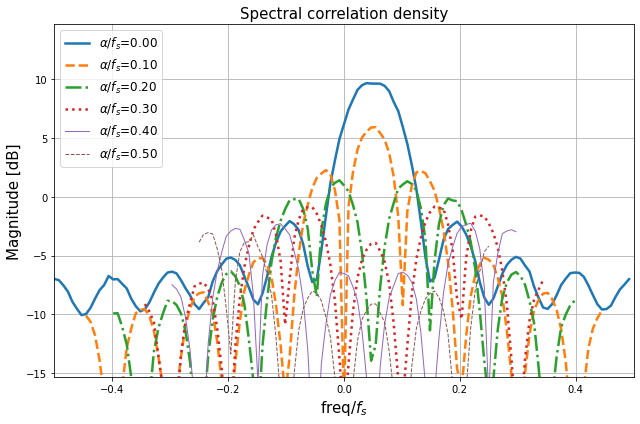

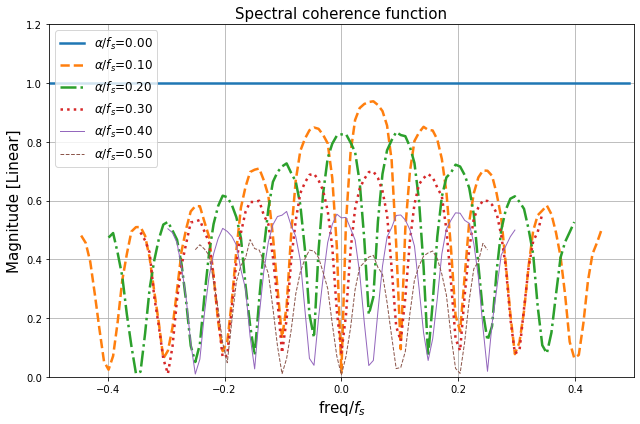

In [6]:
# plot spectral correlation density and spectral coherence in 2D

lines = ['-', '--', '-.', ':']
linewidths = [2.5, 1, 0.5]
N_lines = len(lines)

max_Syy_dB = 10*np.log10(np.nanmax(np.abs(Syy)))

# ----------------------------------------------------------------------------
# plot spectral correlation density

plt.figure(figsize=(9, 6))
for a in range(N_alpha//2+1):
    plt.plot(freq_vec/fs,
             10*np.log10(np.abs(Syy[a, :])),
             linestyle=lines[a%N_lines], linewidth=linewidths[a//N_lines],
             label=r'$\alpha/f_s$={:.2f}'.format(alpha_vec[a]/fs))
plt.legend(loc='upper left', fontsize=12)

plt.xlabel(r'freq/$f_s$', fontsize=15)
plt.xlim([-0.5, 0.5])

plt.ylabel('Magnitude [dB]', fontsize=15)
plt.ylim([max_Syy_dB-25, max_Syy_dB+5])

plt.title('Spectral correlation density', fontsize=15)
plt.grid()
plt.tight_layout()

# ----------------------------------------------------------------------------
# plot spectral coherence
plt.figure(figsize=(9, 6))
for a in range(N_alpha//2+1):
    plt.plot(freq_vec/fs,
             np.abs(rho_y[a, :]),
             linestyle=lines[a%N_lines], linewidth=linewidths[a//N_lines],
             label=r'$\alpha/f_s$={:.2f}'.format(alpha_vec[a]/fs))
plt.legend(loc='upper left', fontsize=12)

plt.xlabel(r'freq/$f_s$', fontsize=15)
plt.xlim([-0.5, 0.5])

plt.ylabel('Magnitude [Linear]', fontsize=15)
plt.ylim([0., 1.2])

plt.title('Spectral coherence function', fontsize=15)
plt.grid()
plt.tight_layout()



We can also plot the same functions in 3D, to better visualise some features.

Text(0.5, 0.92, 'Spectral coherence')

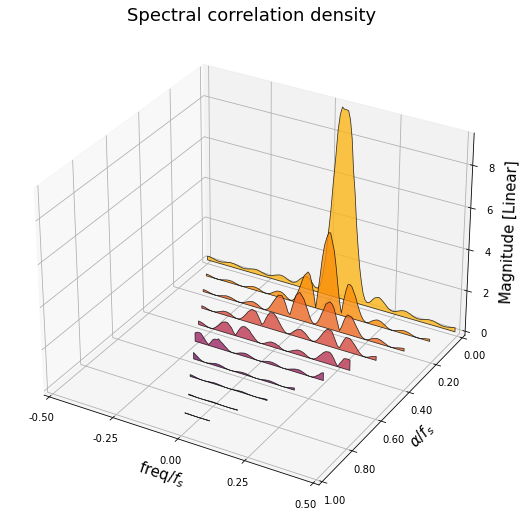

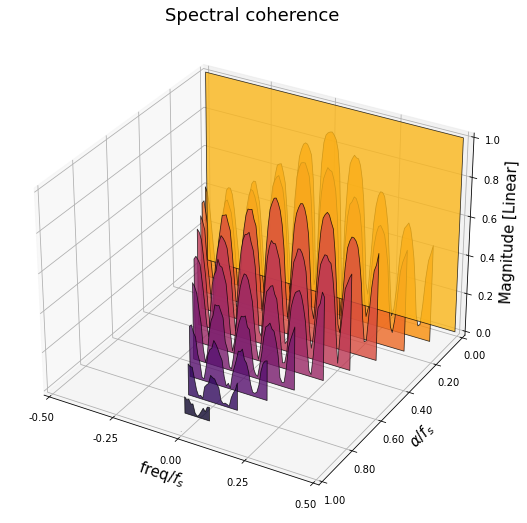

In [7]:
# %% plot spectral correlation density and spectral coherence in 3D

# ----------------------------------------------------------------------------
# These plots were adapted from a Matplotlib example, found at
# https://matplotlib.org/stable/gallery/mplot3d/polys3d.html#sphx-glr-gallery-mplot3d-polys3d-py
# ----------------------------------------------------------------------------

from matplotlib.collections import PolyCollection

def polygon_under_graph(x, y):
    """
    Construct the vertex list which defines the polygon filling the space under
    the (x, y) line graph. This assumes x is in ascending order.
    """
    return [(x[0], 0.), *zip(x, y), (x[-1], 0.)]


# create boolean mask for frequencies inside principal domain in f-alpha plane
freqs_inside = np.zeros((N_alpha, N_psd), dtype='bool')
for a, alpha in enumerate(alpha_vec):
    freqs_inside[a, :] = (np.abs(freq_vec) <= (fs - np.abs(alpha))/2)


# ----------------------------------------------------------------------------
# plot spectral correlation density
fig1 = plt.figure(figsize=(12, 9))
ax1 = fig1.add_subplot(projection='3d')

verts = [polygon_under_graph(freq_vec[freqs_inside[a]]/fs,
                             np.abs(Syy[a, freqs_inside[a]]))
         for a in range(N_alpha)]

# create list of facecolors - incompatible with Matplotlib v3.2.2 currently available
# in Google Colab :(
# facecolors = plt.colormaps['inferno'](np.linspace(0, 1, len(verts)+2))[:len(verts)]

import matplotlib
cmap = matplotlib.cm.get_cmap('inferno')
facecolors = cmap(np.linspace(0, 1, len(verts)+2))[:len(verts)]
transparency = 0.8

poly1 = PolyCollection(verts[::-1], facecolors=facecolors, alpha=transparency,
                       edgecolors='k', linewidths=0.75)
ax1.add_collection3d(poly1, zs=alpha_vec[::-1], zdir='y')

ax1.set(xlim = (-0.5, 0.5),
        ylim = (alpha_vec[-1], alpha_vec[0]),
        zlim = (0., np.nanmax(np.abs(Syy))))

ax1.set_xlabel(r'freq/$f_s$', fontsize=15)
ax1.set_xticks(np.linspace(-0.5, 0.5, 5))
ax1.set_xticklabels(['{:.2f}'.format(f) for f in np.linspace(-0.5, 0.5, 5)])

ax1.set_ylabel(r'$\alpha/f_s$', fontsize=15)
ax1.set_yticks(alpha_vec[::2])
ax1.set_yticklabels(['{:.2f}'.format(a) for a in alpha_vec[::2]])

ax1.set_zlabel('Magnitude [Linear]', fontsize=15)

# set aspect ratio - incompatible with Matplotlib v3.2.2 currently available
# in Google Colab :(
#ax1.set_box_aspect((1, 1, 0.5))

ax1.set_title('Spectral correlation density', fontsize=18)


# ----------------------------------------------------------------------------
# plot coherence
fig2 = plt.figure(figsize=(12, 9))
ax2 = fig2.add_subplot(projection='3d')

verts2 = [polygon_under_graph(freq_vec[freqs_inside[a]]/fs,
                              np.abs(rho_y[a, freqs_inside[a]]))
          for a in range(N_alpha)]


poly2 = PolyCollection(verts2[::-1], facecolors=facecolors, alpha=transparency,
                       edgecolors='k', linewidths=0.75)
ax2.add_collection3d(poly2, zs=alpha_vec[::-1], zdir='y')

ax2.set(xlim = (-0.5, 0.5),
        ylim = (alpha_vec[-1], alpha_vec[0]),
        zlim = (0., 1.))

ax2.set_xlabel(r'freq/$f_s$', fontsize=15)
ax2.set_xticks(np.linspace(-0.5, 0.5, 5))
ax2.set_xticklabels(['{:.2f}'.format(f) for f in np.linspace(-0.5, 0.5, 5)])

ax2.set_ylabel(r'$\alpha/f_s$', fontsize=15)
ax2.set_yticks(alpha_vec[::2])
ax2.set_yticklabels(['{:.2f}'.format(a) for a in alpha_vec[::2]])

ax2.set_zlabel('Magnitude [Linear]', fontsize=15)

# set aspect ratio - incompatible with Matplotlib v3.2.2 currently available
# in Google Colab :(
#ax1.set_box_aspect((1, 1, 0.5))

ax2.set_title('Spectral coherence', fontsize=18)



(**Note**: it might looks like the coherence for 'alpha=0' is appearing "on top" of the coherence for 'alpha' slightly higher than zero. This is a known limitation in Matplotlib, where depending on viewing angle and other parameters the polygons in complex scenes are sometimes rendered in the wrong order - see, for example, [here](https://github.com/matplotlib/matplotlib/issues/3894/).)

Let us now repeat the above analysis for the *conjugate* formulation. The conjugate case requires evaluating the functions over a different range of normalised cyclic frequencies $\alpha/f_s$, as discussed [here](https://cyclostationary.blog/2015/09/28/the-spectral-correlation-function-for-rectangular-pulse-bpsk/) for example.

In [8]:
# run conjugate cyclic periodogram over range of alphas
# --> range of alphas is different for conjugate functions!
N_alpha_c = 19
alpha_vec_c = 2*fc + np.linspace(-N_alpha_c//2, N_alpha_c//2-1, N_alpha_c)*(1/T_bits)

# Conjugate cyclic spectral density
Syy_c = np.zeros((N_alpha, N_psd))

# Conjugate cyclic coherence
rho_y_c = np.zeros((N_alpha, N_psd), dtype='complex')

Syy_c, rho_y_c = cyclic_periodogram(noisy_y, noisy_y, alpha_vec_c, N_psd, fs,
                                    mode='conj')


We now plot the results for the conjugate SCF and conjugate coherence for a few values of cyclic frequency $\alpha$:

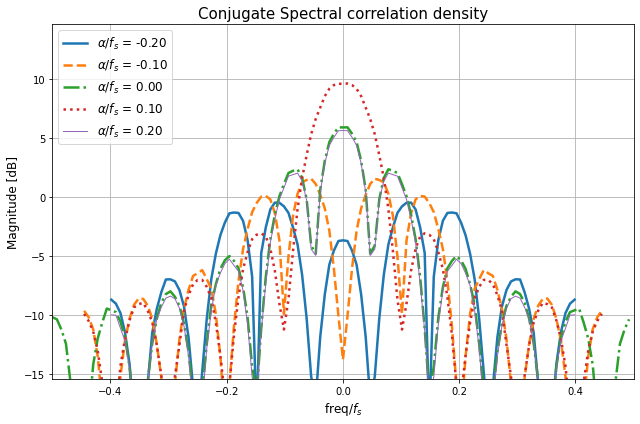

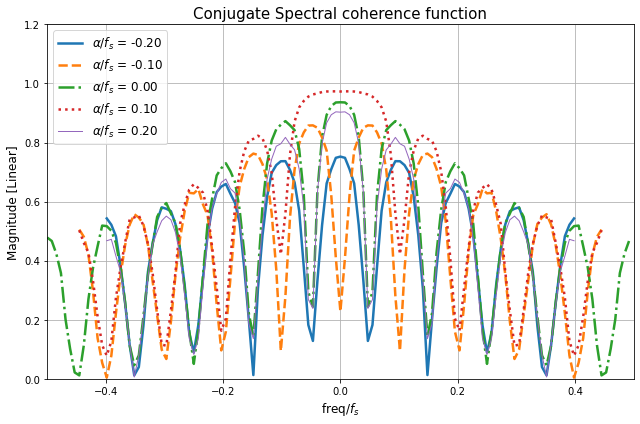

In [9]:
# plot spectral correlation density and spectral coherence in 2D

lines = ['-', '--', '-.', ':']
linewidths = [2.5, 1, 0.5]
N_lines = len(lines)

max_Syyc_dB = 10*np.log10(np.nanmax(np.abs(Syy_c)))

# create boolean mask for frequencies inside principal domain in f-alpha plane
freqs_inside_c = np.zeros((N_alpha_c, N_psd), dtype='bool')
for a, alpha in enumerate(alpha_vec_c):
    freqs_inside_c[a, :] = (np.abs(freq_vec) <= (fs - np.abs(alpha))/2)

# ****************************************************************************
# plot conjugate spectral correlation density

plt.figure(figsize=(9, 6))
for a in range(7, N_alpha_c-7):
    plt.plot(freq_vec/fs,
             10*np.log10(np.abs(Syy_c[a, :])),
             linestyle=lines[(a-7)%N_lines],
             linewidth=linewidths[(a-7)//N_lines],
             label=r'$\alpha/f_s$ = {:.2f}'.format(alpha_vec_c[a]/fs))
plt.legend(loc='upper left', fontsize=12)

plt.xlabel(r'freq/$f_s$', fontsize=12)
plt.xlim([-0.5, 0.5])

plt.ylabel('Magnitude [dB]', fontsize=12)
plt.ylim([max_Syyc_dB-25, max_Syyc_dB+5])

plt.title('Conjugate Spectral correlation density', fontsize=15)
plt.grid()
plt.tight_layout()

# ****************************************************************************
# plot spectral coherence

plt.figure(figsize=(9, 6))
for a in range(7, N_alpha_c-7):
    plt.plot(freq_vec/fs,
             np.abs(rho_y_c[a, :]),
             linestyle=lines[(a-7)%N_lines],
             linewidth=linewidths[(a-7)//N_lines],
             label=r'$\alpha/f_s$ = {:.2f}'.format(alpha_vec_c[a]/fs))
plt.legend(loc='upper left', fontsize=12)

plt.xlabel(r'freq/$f_s$', fontsize=12)
plt.xlim([-0.5, 0.5])

plt.ylabel('Magnitude [Linear]', fontsize=12)
plt.ylim([0., 1.2])

plt.title('Conjugate Spectral coherence function', fontsize=15)
plt.grid()
plt.tight_layout()

And again, we can plot the same functions in 3D to better visualise some features over a wider range of cyclic frequencies.

Text(0.5, 0.92, 'Conjugate Spectral coherence')

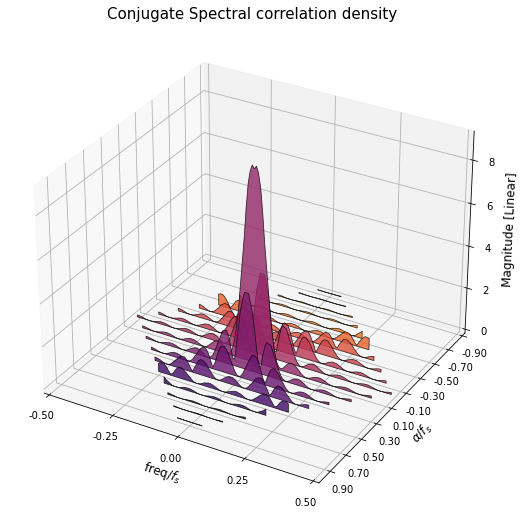

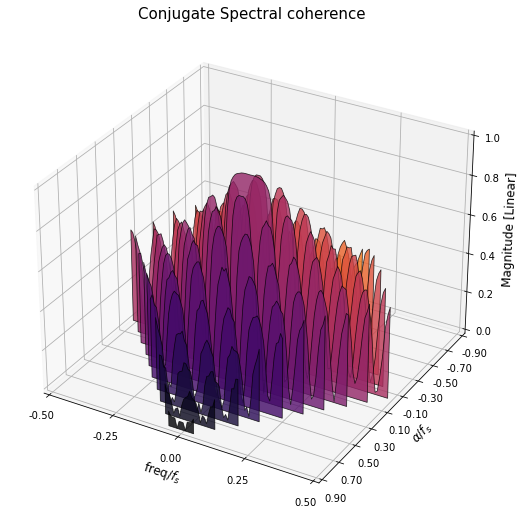

In [10]:
# ****************************************************************************
# plot conjugate Spectral Correlation Density
fig3 = plt.figure(figsize=(12, 9))
ax3 = fig3.add_subplot(projection='3d')

verts_c = [polygon_under_graph(freq_vec[freqs_inside_c[a]]/fs,
                               np.abs(Syy_c[a, freqs_inside_c[a]]))
            for a in range(N_alpha_c)]

# create list of facecolors - incompatible with Matplotlib v3.2.2 currently available
# in Google Colab :(
# facecolors = plt.colormaps['inferno'](np.linspace(0, 1, len(verts)+2))[:len(verts)]

import matplotlib
cmap = matplotlib.cm.get_cmap('inferno')
facecolors_c = cmap(np.linspace(0, 1, len(verts_c)+2))[:len(verts_c)]

transparency = 0.8

poly3 = PolyCollection(verts_c[::-1],
                        facecolors=facecolors_c, alpha=transparency,
                        edgecolors='k', linewidths=0.75)
ax3.add_collection3d(poly3, zs=alpha_vec_c[::-1], zdir='y')

ax3.set(xlim = (-0.5, 0.5),
        ylim = (alpha_vec[-1], alpha_vec[0]),
        zlim = (0., np.nanmax(np.abs(Syy_c))))

ax3.set_xlabel(r'freq/$f_s$', fontsize=12)
ax3.set_xticks(np.linspace(-0.5, 0.5, 5),
              labels=['{:.2f}'.format(f) for f in np.linspace(-0.5, 0.5, 5)])

ax3.set_ylabel(r'$\alpha/f_s$', fontsize=12)
ax3.set_yticks(alpha_vec_c[::2])
ax3.set_yticklabels(['{:.2f}'.format(a) for a in alpha_vec_c[::2]])

ax3.set_zlabel('Magnitude [Linear]', fontsize=12)

# set aspect ratio - incompatible with Matplotlib v3.2.2 currently available
# in Google Colab :(
#ax1.set_box_aspect((1, 1, 0.5))

ax3.set_title('Conjugate Spectral correlation density', fontsize=15)


# ****************************************************************************
# plot conjugate coherence
fig4 = plt.figure(figsize=(12, 9))
ax4 = fig4.add_subplot(projection='3d')

verts4 = [polygon_under_graph(freq_vec[freqs_inside_c[a]]/fs,
                              np.abs(rho_y_c[a, freqs_inside_c[a]]))
          for a in range(N_alpha_c)]


poly4 = PolyCollection(verts4[::-1],
                        facecolors=facecolors_c, alpha=transparency,
                        edgecolors='k', linewidths=0.75)
ax4.add_collection3d(poly4, zs=alpha_vec_c[::-1], zdir='y')

ax4.set(xlim = (-0.5, 0.5),
        ylim = (alpha_vec_c[-1], alpha_vec_c[0]),
        zlim = (0., 1.))

ax4.set_xlabel(r'freq/$f_s$', fontsize=12)
ax4.set_xticks(np.linspace(-0.5, 0.5, 5),
                labels=['{:.2f}'.format(f) for f in np.linspace(-0.5, 0.5, 5)])

ax4.set_ylabel(r'$\alpha/f_s$', fontsize=12)
ax4.set_yticks(alpha_vec_c[::2])
ax4.set_yticklabels(['{:.2f}'.format(a) for a in alpha_vec_c[::2]])

ax4.set_zlabel('Magnitude [Linear]', fontsize=12)

# set aspect ratio - incompatible with Matplotlib v3.2.2 currently available
# in Google Colab :(
#ax1.set_box_aspect((1, 1, 0.5))

ax4.set_title('Conjugate Spectral coherence', fontsize=15)